In [10]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp

In [2]:
G = nx.barabasi_albert_graph(1000, 10, seed = 1)
C = nx.clustering(G)

In [26]:
nx.write_edgelist(G, 'fakegraph.adjlist')


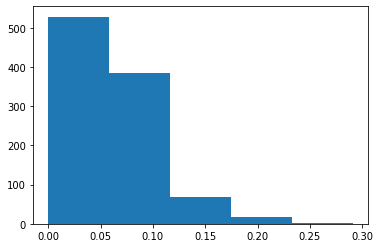

In [3]:
BINs = plt.hist(list(C.values()), bins = 5)

In [4]:
BINs

(array([528., 385.,  68.,  18.,   1.]),
 array([0.        , 0.05818182, 0.11636364, 0.17454545, 0.23272727,
        0.29090909]),
 <a list of 5 Patch objects>)

In [5]:
def aug_normalized_adjacency(adj):
    adj = adj + sp.eye(adj.shape[0])
    adj = sp.coo_matrix(adj)
    row_sum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(row_sum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return d_mat_inv_sqrt.dot(adj).dot(d_mat_inv_sqrt).tocoo()

def row_normalize(mx):
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

In [22]:
A = nx.adjacency_matrix(G)
A = aug_normalized_adjacency(A)

In [11]:
features = np.eye(A.shape[0])
features = row_normalize(features)

In [14]:
from scipy.sparse import csr_matrix, isspmatrix
isspmatrix(A)

True

In [15]:
labels = np.zeros(A.shape[0], )

In [16]:
tmp = np.array(list(C.values()))
label_count = 5
for i in range(label_count):
    thr_down = np.percentile(tmp, i*(100/label_count))
    thr_up = np.percentile(tmp,(i+1)*(100/label_count))
    labels[np.where((tmp <= thr_up) & (tmp > thr_down))] = i

In [17]:
data_graph = [A, features, labels]

In [18]:
np.savez('fake_graph.npz', A, features, labels)

In [21]:
isspmatrix(np.load('fake_graph.npz', allow_pickle = True)['arr_0'])

False

In [97]:
np.unique(labels)

array([0., 1., 2., 3., 4.])

In [34]:
import numpy as np
import scipy.sparse as sp
import torch
import sys
import pickle as pkl
import networkx as nx
#from normalization import fetch_normalization, row_normalize
from sklearn.metrics import f1_score

In [ ]:
def load_citation(dataset_str="cora", normalization="AugNormAdj", cuda=True):
    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
    objects = []
    for i in range(len(names)):
        with open("data/ind.{}.{}".format(dataset_str.lower(), names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))

    x, y, tx, ty, allx, ally, graph = tuple(objects)
    test_idx_reorder = parse_index_file("data/ind.{}.test.index".format(dataset_str))
    test_idx_range = np.sort(test_idx_reorder)

    if dataset_str == 'citeseer':
        test_idx_range_full = range(min(test_idx_reorder), max(test_idx_reorder)+1)
        tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
        tx_extended[test_idx_range-min(test_idx_range), :] = tx
        tx = tx_extended
        ty_extended = np.zeros((len(test_idx_range_full), y.shape[1]))
        ty_extended[test_idx_range-min(test_idx_range), :] = ty
        ty = ty_extended

    features = sp.vstack((allx, tx)).tolil()
    features[test_idx_reorder, :] = features[test_idx_range, :]
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
    labels = np.vstack((ally, ty))
    labels[test_idx_reorder, :] = labels[test_idx_range, :]


    adj, features = preprocess_citation(adj, features, normalization)

    features = torch.FloatTensor(np.array(features.todense())).float()
    labels = torch.LongTensor(labels)
    labels = torch.max(labels, dim=1)[1]
    adj = sparse_mx_to_torch_sparse_tensor(adj).float()

    if cuda:
        features = features.cuda()
        adj = adj.cuda()
        labels = labels.cuda()

    return adj, features, labels

In [37]:
names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
dataset_str="cora"
objects = []
for i in range(len(names)):
    with open("../meta_gnn/data/ind.{}.{}".format(dataset_str.lower(), names[i]), 'rb') as f:
        if sys.version_info > (3, 0):
            objects.append(pkl.load(f, encoding='latin1'))
        else:
            objects.append(pkl.load(f))

x, y, tx, ty, allx, ally, graph = tuple(objects)
test_idx_reorder = parse_index_file("../meta_gnn/data/ind.{}.test.index".format(dataset_str))
test_idx_range = np.sort(test_idx_reorder)

features = sp.vstack((allx, tx)).tolil()
features[test_idx_reorder, :] = features[test_idx_range, :]
adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))

In [36]:
def parse_index_file(filename):
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index

In [45]:
adj.multiply(adj.T > adj)

<2708x2708 sparse matrix of type '<class 'numpy.int64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [42]:
adj.multiply(adj.T > adj)

<2708x2708 sparse matrix of type '<class 'numpy.int64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [44]:
adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
adj

<2708x2708 sparse matrix of type '<class 'numpy.int64'>'
	with 10556 stored elements in Compressed Sparse Row format>